## Introduction

The aim of this assignment is to create a Message Passing Interface (MPI) program to compute the product of two nxn dense matrix on p processors using the 2-dimensional parallel algorithm.

The matrices are equally partitioned into squares of size $\sqrt{p}*\sqrt{p}$ and each processor has to compute the product of their assigned square.

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import matplotlib.gridspec as gridspec

plt.style.use('ggplot')

# Code explanation

First, we initiate MPI computation and get the numbers of processors and ranks on all processors
```c++
// line 54
MPI_Init(&argc, &argv);
MPI_Comm_size(MPI_COMM_WORLD, &nb_procs);
MPI_Comm_rank(MPI_COMM_WORLD, &rank);
``` 

We compute the size of the partitions using the square root of the number of processors
```c++
// line 58
m_part = m_size/(int)sqrt(nb_procs);
```

For each partition, we assign a row and column number using their rank. The top-left partition is assigned to process 0, top-right one is assigned to process `m_part` and bottom-right one to `nb_procs-1`. We then create one communicator per row and per column to group partitions from the same row and same columns.
```c++
// line 65 
row = rank / (m_size/m_part);
col = rank % (m_size/m_part);
// line 75
MPI_Comm_split(MPI_COMM_WORLD, row, rank, &rowcomm);
MPI_Comm_split(MPI_COMM_WORLD, col, rank, &colcomm);
```

Using these communicators, we can gather partitions of the same row or the same columns into a single array `arows` for the full row from matrix A and `bcols` for the full column from matrix B.
```c++
// line 83
MPI_Allgather(a, m_part * m_part, MPI_DOUBLE, arows, m_part * m_part, MPI_DOUBLE, rowcomm);
MPI_Allgather(b, m_part * m_part, MPI_DOUBLE, bcols, m_part * m_part, MPI_DOUBLE, colcomm);
```

Finally, we can compute the partitioned square with `arows` and `bcols`, paying attention to how the data is organized inside:
```c++
// line 86
for (i = 0; i < m_part; i++)
{
    for (j = 0; j < m_part; j++)
    {
        sum = 0.0;
        ind1 = 0;
        ind2 = 0;
        for (k = 0; k < m_size; k++)
        {
            sum += arows[ind1+ind2+i*m_part] * bcols[m_part*k+j];
            if (ind1 < m_part-1) {
                ind1 += 1;
            } else {
                ind1 = 0;
                ind2 += m_part*m_part;
            }
        }
        c[i*m_part+j] = sum;
    }
}
``` 

In order to print the full matrix, we can again use the `MPI_Gather` routine to gather all partitions of matrix C in a single structure within one processor (rank 0):
```c++
// line 114
if (rank == 0) 
{
    ...
    all_c = malloc(m_size * m_size * sizeof(double));
}

...
MPI_Gather(c, m_part * m_part, MPI_DOUBLE, all_c, m_part * m_part, MPI_DOUBLE, 0, MPI_COMM_WORLD);

if (rank == 0)
{
    ...
    printf("C =\n");
    print_blocked_matrix(m_size, m_part, all_c);
}
```

# Benchmarks of parallel and serial programs for difference matrix size

## Benchmark of parallel programs

In [20]:
parallel = pd.read_csv("data_parallel.csv")
parallel

,matrix_size,nb_procs,timing
0,200,16,0.753530
1,400,16,2.424793
2,600,16,8.808398
3,800,16,17.239664
4,1000,16,64.099222
5,1200,16,83.059078
6,1400,16,231.324885
7,1600,16,358.354298
8,1800,16,624.600948


## Benchmark of serial programs

In [21]:
serial = pd.read_csv("data_serial.csv")
serial

,matrix_size,timing
0,200,0.163096
1,400,1.656834
2,600,8.548769
3,800,23.771984
4,1000,69.186296
5,1200,158.167581
6,1400,283.427194
7,1600,473.548842
8,1800,761.952090


# Dependence of the execution time of the program on the matrix size n

Text(0.5, 1.0, 'Execution time of parallel programs in function of the matrix size (p = 16)')

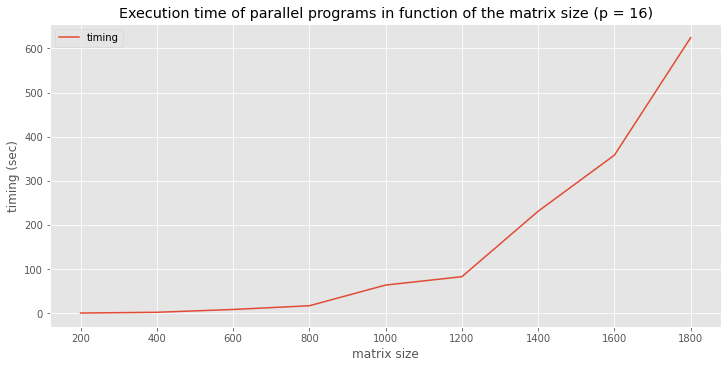

In [22]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax = fig.add_subplot(111)
parallel.plot.line(x='matrix_size', y='timing', ax=ax)
ax.set_xlabel('matrix size')
ax.set_ylabel('timing (sec)')
ax.set_title('Execution time of parallel programs in function of the matrix size (p = 16)')

# Speedup over a serial counterpart of the program

Speedup is calculated as follows: 
$$S(m) = \frac{T_{serial}(m)}{T_{parallel}(m)}$$ 
where $m$ is matrix size

In [23]:
parallel['speedup'] = serial['timing'] / parallel['timing']
parallel

,matrix_size,nb_procs,timing,speedup
0,200,16,0.753530,0.216442
1,400,16,2.424793,0.683289
2,600,16,8.808398,0.970525
3,800,16,17.239664,1.378912
4,1000,16,64.099222,1.079363
5,1200,16,83.059078,1.904278
6,1400,16,231.324885,1.225234
7,1600,16,358.354298,1.321454
8,1800,16,624.600948,1.219902


Text(0.5, 1.0, 'Speedup of parallel programs over their serial counterparts')

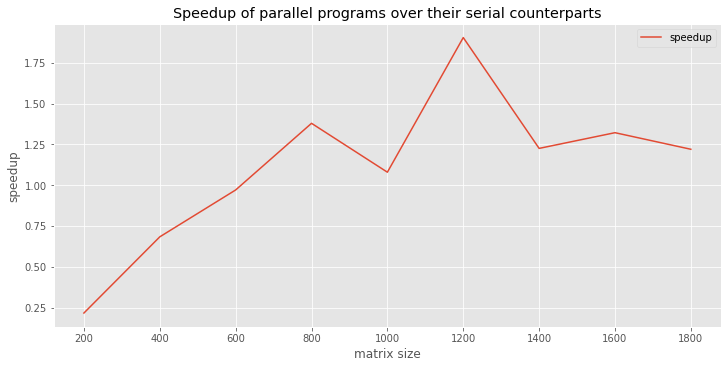

In [24]:
fig = plt.figure(constrained_layout=True, figsize=(10, 5))
ax = fig.add_subplot(111)
parallel.plot.line(x='matrix_size', y='speedup', ax=ax)
ax.set_xlabel('matrix size')
ax.set_ylabel('speedup')
ax.set_title('Speedup of parallel programs over their serial counterparts')

The results show that we start to have a significant speedup for matrix of size n > 600 and the speedup stabilises around 1.5 for bigger matrices. 

The parallelisation is inefficient for small matrices as it reduces the processing speed. It is also not as efficient x as when we use a parallel library such as OpenMP for bigger matrix where speedup would reach about 4 or 5. This difference in performance may be due to communication and message passing overhead since processes have to wait for other processes to complete. 

To improve the performance of the parallel program, we may consider duplicating locally needed rows and columns for the computation of a partition instead of using `MPI_Allgather` to reduce communication time.